In [4]:
import numpy as np
import pandas as pd
import os
import zipfile

ZIP_PATH = './archive.zip' 
DATA_DIR = './lgg-mri-segmentation/' 

if not os.path.exists(DATA_DIR):
    print(f"'{DATA_DIR}' not found. Extracting '{ZIP_PATH}'...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('./')
else:
    print(f"Directory '{DATA_DIR}' already exists.")

file_count = 0
for dirname, _, filenames in os.walk(DATA_DIR):
    if file_count < 5: 
        for filename in filenames:
            print(os.path.join(dirname, filename))
            file_count += 1
    else:
        break 

all_files = [f for d, _, fs in os.walk(DATA_DIR) for f in fs]
total_images = sum(1 for f in all_files if 'mask' not in f)
total_masks = sum(1 for f in all_files if 'mask' in f)

print(f"\nTotal number of MRI images: {total_images}")
print(f"Total number of masks: {total_masks}")

Directory './lgg-mri-segmentation/' already exists.
./lgg-mri-segmentation/kaggle_3m\data.csv
./lgg-mri-segmentation/kaggle_3m\README.md
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_1.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_11.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_11_mask.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12_mask.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_13.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_13_mask.tif
./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_14.tif
./lg

Selected patient for visualization: TCGA_CS_6186_20000601
Image shape: (256, 256, 3)
Mask shape: (256, 256)


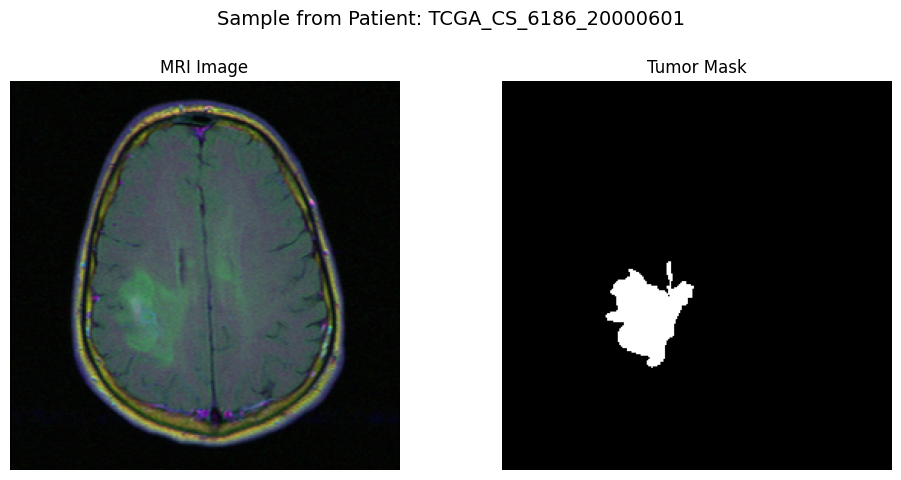

In [7]:
import cv2
import matplotlib.pyplot as plt
import os
import random

MAIN_DATA_PATH = os.path.join(DATA_DIR, 'kaggle_3m')

patient_folders = [f for f in os.listdir(MAIN_DATA_PATH) if os.path.isdir(os.path.join(MAIN_DATA_PATH, f))]
random_patient = random.choice(patient_folders)
patient_path = os.path.join(MAIN_DATA_PATH, random_patient)
print(f"Selected patient for visualization: {random_patient}")

image_files = [f for f in os.listdir(patient_path) if f.endswith(".tif") and "mask" not in f]
random_image_file = random.choice(image_files)
img_path = os.path.join(patient_path, random_image_file)

mask_path = img_path.replace(".tif", "_mask.tif")

img = cv2.imread(img_path) 
mask = cv2.imread(mask_path, 0) 

print(f"Image shape: {img.shape}")  
print(f"Mask shape: {mask.shape}")   

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
plt.title("MRI Image")
plt.axis('off') 

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray') 
plt.title("Tumor Mask")
plt.axis('off')

plt.suptitle(f'Sample from Patient: {random_patient}', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

DATA_DIR = "lgg-mri-segmentation/kaggle_3m/"

images = []
masks = []

for patient in os.listdir(DATA_DIR):
    patient_path = os.path.join(DATA_DIR, patient)
    if not os.path.isdir(patient_path):
        continue
    
    for file in os.listdir(patient_path):
        if file.endswith(".tif") and "mask" not in file:
            img_path = os.path.join(patient_path, file)
            mask_path = img_path.replace(".tif", "_mask.tif")
            
            img = cv2.imread(img_path)           
            mask = cv2.imread(mask_path, 0)      
            img = cv2.resize(img, (128,128))
            mask = cv2.resize(mask, (128,128))
            
            img = img / 255.0
            mask = mask / 255.0
            
            images.append(img)
            masks.append(mask)

images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

masks = np.expand_dims(masks, axis=-1)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (3929, 128, 128, 3)
Masks shape: (3929, 128, 128, 1)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (3143, 128, 128, 3) (3143, 128, 128, 1)
Val: (786, 128, 128, 3) (786, 128, 128, 1)


In [14]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).shuffle(100)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

In [15]:
IMG_SIZE = (128, 128)

def parse_image_mask(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)    
    img = tf.image.resize(img, IMG_SIZE) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask > 127, tf.float32) 
    return img, mask

In [16]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.4)
])

In [17]:
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2,2), strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(224,224,3)):
    inputs = layers.Input(input_shape)
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    b = conv_block(p4, 1024)

    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(d4)
    model = Model(inputs, outputs)
    return model

In [18]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [19]:
model = build_unet((128,128,3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_dice_coef', mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=8, mode='max', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
]

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20,
                    callbacks=callbacks)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.0610 - loss: 0.3772

197/197 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - dice_coef: 0.1251 - loss: 0.1350 - val_dice_coef: 0.2046 - val_loss: 0.0273 - learning_rate: 0.0010
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.2165 - loss: 0.0328

197/197 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - dice_coef: 0.2536 - loss: 0.0299 - val_dice_coef: 0.3605 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.3337 - loss: 0.0260

197/197 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - dice_coef: 0.3641 - loss: 0.0248 - val_dice_coef: 0.4089 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.3872 - loss: 0.0236

197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - dice_coef: 0.4175 - loss: 0.0231 - val_dice_coef: 0.4191 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - dice_coef: 0.4495 - loss: 0.0213 - val_dice_coef: 0.4010 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.4911 - loss: 0.0192

197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - dice_coef: 0.5021 - loss: 0.0190 - val_dice_coef: 0.5529 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - dice_coef: 0.5268 - loss: 0.0180 - val_dice_coef: 0.4159 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - dice_coef: 0.5654 - loss: 0.0163 - val_dice_coef: 0.5051 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - dice_coef: 0.5773 - loss: 0.0161 - val_dice_coef: 0.5243 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.6086 - loss: 0.0133

197/197 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - dice_coef: 0.6273 - loss: 0.0135 - val_dice_coef: 0.6518 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 11/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - dice_coef: 0.6278 - loss: 0.0136 - val_dice_coef: 0.6230 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 12/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.6911 - loss: 0.0107

197/197 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - dice_coef: 0.6939 - loss: 0.0107 - val_dice_coef: 0.7034 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 13/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - dice_coef: 0.7217 - loss: 0.0097 - val_dice_coef: 0.6310 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 14/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - dice_coef: 0.7312 - loss: 0.0093 - val_dice_coef: 0.7024 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 15/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.7552 - loss: 0.0084

197/197 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - dice_coef: 0.7357 - loss: 0.0093 - val_dice_coef: 0.7225 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 16/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - dice_coef: 0.7638 - loss: 0.0080 - val_dice_coef: 0.6775 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 17/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.7900 - loss: 0.0068

197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - dice_coef: 0.7977 - loss: 0.0067 - val_dice_coef: 0.7774 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 18/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - dice_coef: 0.8003 - loss: 0.0067 - val_dice_coef: 0.7445 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 19/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.7912 - loss: 0.0080

197/197 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - dice_coef: 0.7995 - loss: 0.0069 - val_dice_coef: 0.8068 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 20/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - dice_coef: 0.8155 - loss: 0.0061 - val_dice_coef: 0.7852 - val_loss: 0.0079 - learning_rate: 0.0010


In [41]:
for imgs, masks in val_dataset.take(1):
    gt = masks[0].numpy()            # ground truth لعنصر واحد
    pred = model.predict(np.expand_dims(imgs[0].numpy(), axis=0))[0,:,:,0]  # احتمالات
    break

print("GT dtype, min, max, unique counts:", gt.dtype, gt.min(), gt.max(), np.unique(gt)[:10])
print("Pred dtype, min, max:", pred.dtype, pred.min(), pred.max())
print("GT sum (pixels):", gt.sum())
print("Pred sum (pixels, >0.5):", (pred > 0.5).sum())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
GT dtype, min, max, unique counts: float32 0.0 0.0 [0.]
Pred dtype, min, max: float32 4.712036e-17 0.00016573314
GT sum (pixels): 0.0
Pred sum (pixels, >0.5): 0


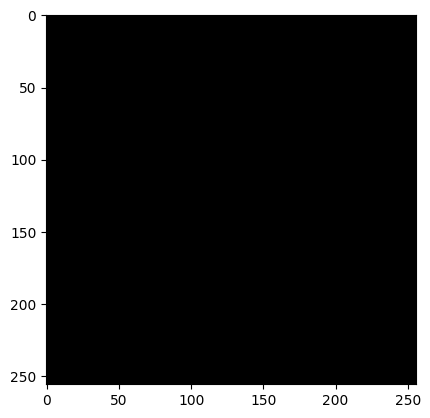

Mask unique: [0]


In [42]:
mask = cv2.imread(mask_path, 0)  
plt.imshow(mask, cmap='gray')
plt.show()
print("Mask unique:", np.unique(mask))

In [43]:
import glob

DATA_DIR = './lgg-mri-segmentation/kaggle_3m/'

all_files = glob.glob(os.path.join(DATA_DIR, "*", "*.tif"))

mask_paths = sorted([f for f in all_files if "mask" in f])
image_paths = sorted([f for f in all_files if "mask" not in f])

print(f"Number of images found: {len(image_paths)}")
print(f"Number of masks found: {len(mask_paths)}")
print(f"Sample image path: {image_paths[0]}")
print(f"Sample mask path: {mask_paths[0]}")


Number of images found: 3929
Number of masks found: 3929
Sample image path: ./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_1.tif
Sample mask path: ./lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif


Image shape: (256, 256, 3)
Mask shape: (256, 256)


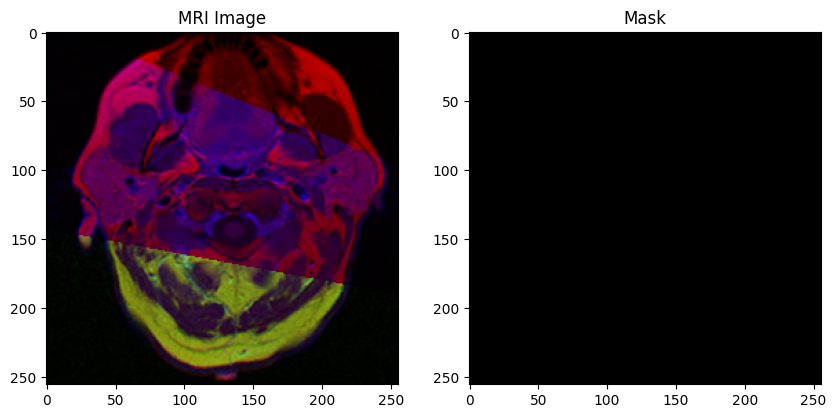

In [44]:
img_path = "lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif"
mask_path = "lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif"

sample_img = cv2.imread(img_path)
sample_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

print("Image shape:", sample_img.shape if sample_img is not None else "Image not loaded")
print("Mask shape:", sample_mask.shape if sample_mask is not None else "Mask not loaded")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)); plt.title("MRI Image")
plt.subplot(1,2,2); plt.imshow(sample_mask, cmap="gray"); plt.title("Mask")
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 649ms/step - dice_coef: 0.8068 - loss: 0.0073
Validation Loss: 0.0073
Validation Dice Coefficient: 0.8068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


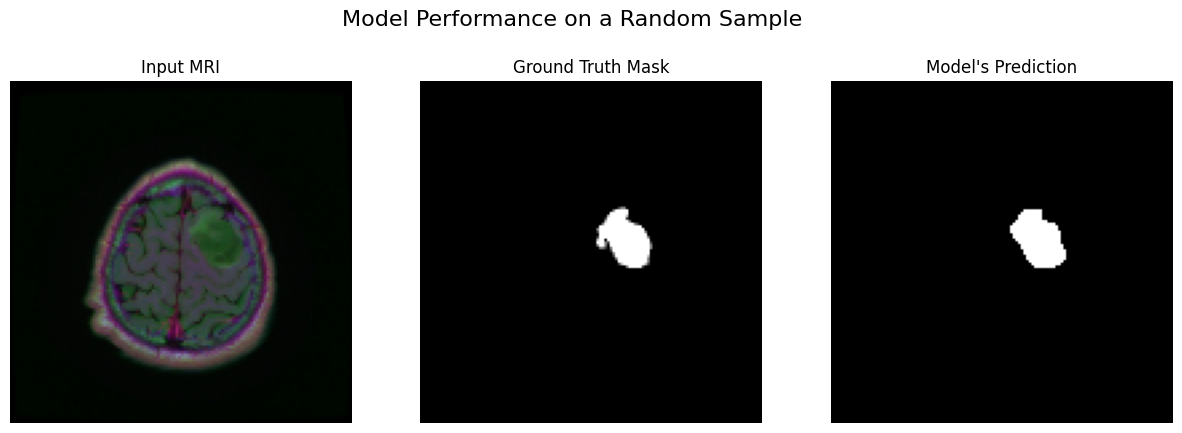

In [48]:
import numpy as np

val_loss, val_dice = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Dice Coefficient: {val_dice:.4f}")

for img_batch, mask_batch in val_dataset.shuffle(buffer_size=100).take(1):
    original_img = img_batch[0].numpy()
    ground_truth_mask = mask_batch[0].numpy()

    predicted_mask_raw = model.predict(np.expand_dims(original_img, axis=0))
    predicted_mask = (predicted_mask_raw[0] > 0.5).astype(np.uint8)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Input MRI")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask.squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap="gray")
    plt.title("Model's Prediction")
    plt.axis("off")

    plt.suptitle("Model Performance on a Random Sample", fontsize=16)
    plt.show()
    break

In [49]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred > 0.5, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coef])

In [50]:
loss, acc, dice = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Dice Coefficient: {dice:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9968 - dice_coef: 0.8632 - loss: 0.0073
Validation Accuracy: 0.9968
Validation Dice Coefficient: 0.8632


In [51]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5", custom_objects={"dice_coef": dice_coef})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


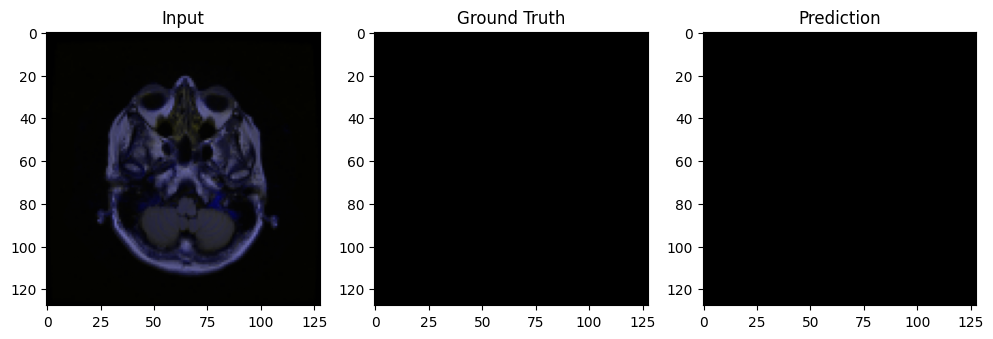

In [53]:
sample_img = X_val[0]
sample_mask = y_val[0]

pred_mask = model.predict(np.expand_dims(sample_img, axis=0))[0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sample_img); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(sample_mask.squeeze(), cmap='gray'); plt.title("Ground Truth")
plt.subplot(1,3,3); plt.imshow(pred_mask.squeeze() > 0.5, cmap='gray'); plt.title("Prediction")
plt.show()
